Throughout this document the following imports and styles are used.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Goal

In this document we will be testing a multiple exponential moving average crossover strategy. We will also create an entry position calculated with a Fibonacci between the point of the crossover and the low/high of the candle.

## Issues with our model

This model still has a few unsolved issues:

1. We have created a target price for which the older should be opened. It is however opened on the close price for the candle where the target price is hit with the high or low. The assumption is that it gives minimal effect.

2. Short position P/L is perhaps not calculated correctly. 

# Imports

## General libraries

These are the general Python libraries that are used.

In [2]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

## Custom libraries

These are the custom libraries that hold the framework to perform and analyze a backtest.

In [3]:
import poloniex as plnx
import ta_lib as ta
import signals as sg
import backtest as bt

# Technical Analysis for Trading Signals

To run a backtest trading simulation we will need to set it up with parameters. The parameters will be explained per section.

## Chart data

We are using data from http://www.poloniex.com API. Our test is done on the `USDT_BTC` pair..

In [4]:
pair = 'USDT_BTC'
timeframe = 120 * 60
end = datetime.utcnow()
start = end - timedelta(days=90)
chart = plnx.get_chart(pair, timeframe, start, end)

## Technical Indicators

We will be using the following technical indicators to generate signals:

In [5]:
ta.ema(chart, 8)
ta.ema(chart, 13)
ta.ema(chart, 21)
ta.ema(chart, 55)

In [6]:
chart[50:60]

,close,date,high,low,open,ema8,ema13,ema21,ema55
50,10613.197400,2018-02-22 01:00:00,10640.000000,10229.250000,10441.060500,10502.409864,10604.532079,10798.525788,NaN
51,10711.935002,2018-02-22 03:00:00,10793.335800,10590.560000,10614.295600,10548.402275,10613.661412,10781.787100,NaN
52,10783.000000,2018-02-22 05:00:00,10850.000000,10600.000000,10713.642800,10608.232963,10637.334093,10773.703234,NaN
53,10622.949099,2018-02-22 07:00:00,10912.000000,10540.000000,10782.171440,10613.418358,10630.814609,10747.305240,NaN
54,10340.200000,2018-02-22 09:00:00,10670.241721,10303.380000,10605.127481,10540.261468,10571.070481,10693.029788,10890.570951
55,10235.213100,2018-02-22 11:00:00,10368.646686,10059.000000,10340.200000,10459.813472,10500.843929,10630.105238,10863.586329
56,9887.448472,2018-02-22 13:00:00,10322.276319,9779.084262,10235.213101,10307.404098,10386.008795,10536.026440,10821.760495
57,9986.769300,2018-02-22 15:00:00,10130.023998,9750.000000,9898.404696,10214.936842,10309.981810,10461.020281,10784.948476
58,9850.560000,2018-02-22 17:00:00,10074.000000,9722.224192,9986.638585,10102.922868,10225.189481,10384.779582,10745.838441
59,10019.468000,2018-02-22 19:00:00,10050.000000,9772.197993,9851.439072,10062.698743,10183.526734,10335.899999,10717.271114


## Signals

We will be using multiple EMA's to generate crossover signals.

In [7]:
chart['open_long'] = chart['open_short'] = chart['close_long'] = chart['close_short'] = 0

In [8]:
def getFib(crossover_price, candle_high_low, lvl): return crossover_price-(crossover_price-candle_high_low)*lvl

In [9]:
head = 56
ema1 = 'ema8'
ema2 = 'ema13'
ema3 = 'ema21'
ema4 = 'ema55'

chart['crossover'] = chart['target_price'] = chart['target_low'] = chart['dbg_long'] = chart['dbg_short'] = 0
state = 'none'
order_filled = False

for i in range(head, len(chart.index)):
    p1 = chart.loc[i, ema1] - chart.loc[i, ema4]
    p2 = chart.loc[i, ema2] - chart.loc[i, ema4]
    p3 = chart.loc[i, ema3] - chart.loc[i, ema4]
    if(p1 > 0 and p2 > 0 and p3 > 0): chart.loc[i, 'crossover'] = 1
    if(p2 < 0 and p2 < 0 and p3 < 0): chart.loc[i, 'crossover'] = -1
    prev = chart.loc[i-1, 'crossover']
    current = chart.loc[i, 'crossover']
    
    chart.loc[i, 'target_price'] = chart.loc[i-1, 'target_price']
    
    if (prev == -1 or prev == 0) and current == 1: 
        if state == 'short' and order_filled:
            chart.loc[i, 'close_short'] = 1
        state = 'long'
        chart.loc[i, 'target_price'] = getFib(chart.loc[i, ema4], chart.loc[i, 'low'],.702)
        chart.loc[i, 'dbg_long'] = 1
        order_filled = False
        
    if (prev == 1 or prev == 0) and current == -1: 
        if state == 'long' and order_filled:
            chart.loc[i, 'close_long'] = 1
        state = 'short'
        chart.loc[i, 'target_price'] = getFib(chart.loc[i, ema4], chart.loc[i, 'high'],.702)
        chart.loc[i, 'dbg_short'] = 1
        order_filled = False
         
    if state == 'long' and not order_filled:
        if chart.loc[i, 'target_price'] > chart.loc[i, 'low']:
            chart.loc[i, 'open_long'] = 1
            order_filled = True

    if state == 'short' and not order_filled:
        if chart.loc[i, 'target_price'] < chart.loc[i, 'high']:
            chart.loc[i, 'open_short'] = 1
            order_filled = True

## Plotting strategy indicators

If we plot all our technical indicators in a chart.

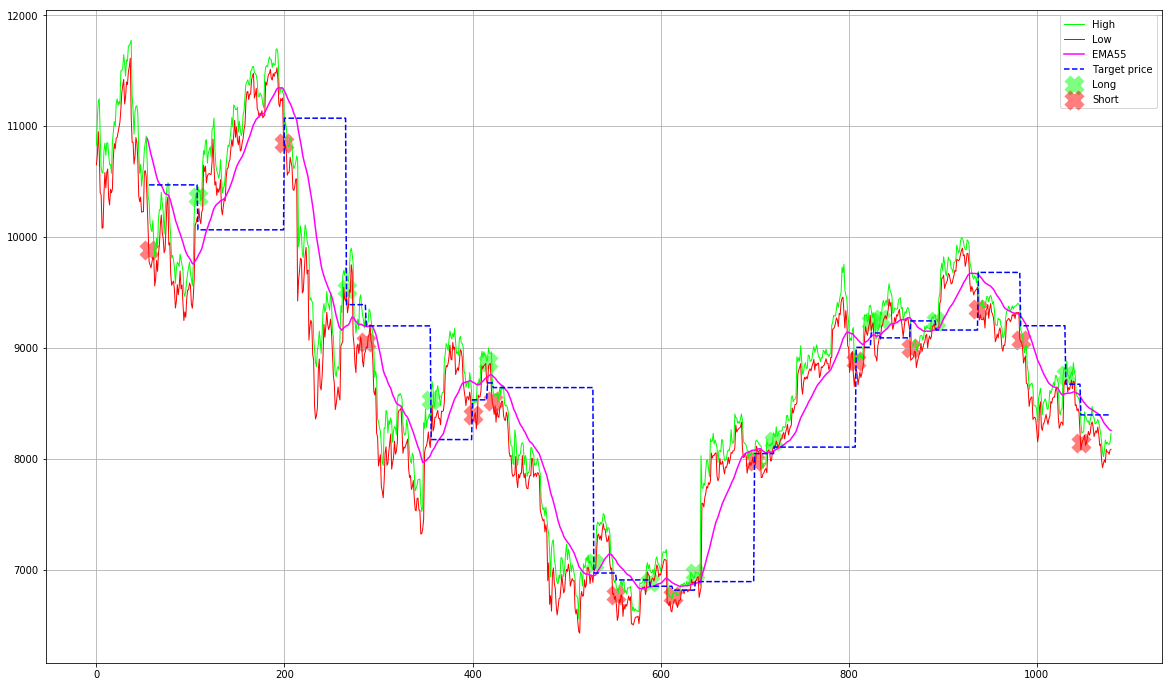

In [10]:
plt.figure(figsize(20,12))
plot(chart['high'], c='lime', lw=1, alpha=1)
plot(chart['low'], c='red', lw=1, alpha=1)
plot(chart['ema55'], c='magenta')
plot(chart.loc[chart['target_price'] > 0]['target_price'], c='b', ls='dashed')
dbg_long = chart.loc[chart['dbg_long'] > 0]
dbg_short = chart.loc[chart['dbg_short'] > 0]
scatter(dbg_long.index, dbg_long['close'], c='lime', lw=20, marker='x', alpha=0.5)
scatter(dbg_short.index, dbg_short['close'], c='red', lw=20, marker='x', alpha=0.5)
legend(['High', 'Low', 'EMA55', 'Target price', 'Long', 'Short'])
grid()

### Close and EMA55 distance indicator

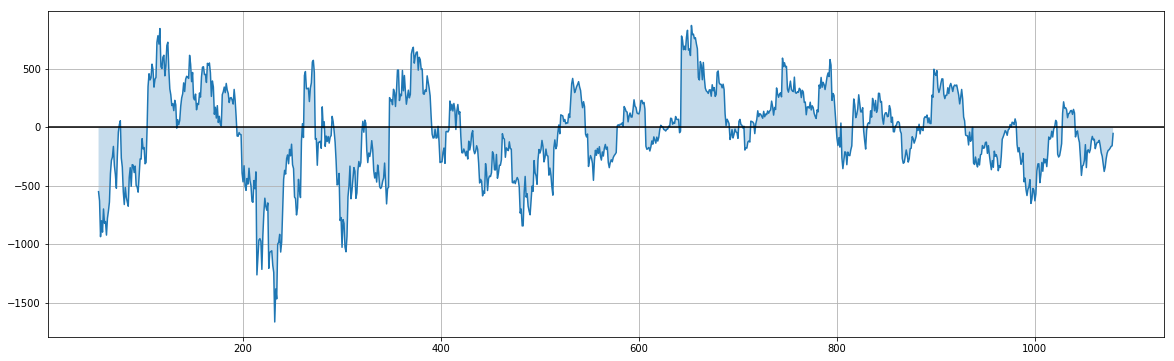

In [11]:
plt.figure(figsize(20,6))
chart['dist'] = chart['close'] - chart['ema55']
plot(chart['dist'])
fill_between(range(len(chart.index)), chart['dist'], alpha=0.25)
axhline(0,c='black')
grid()

### EMA crossover indicator

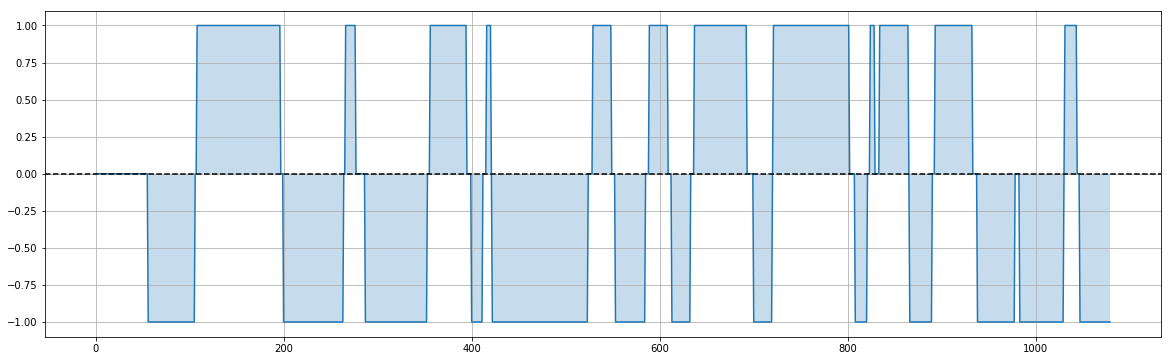

In [12]:
plot(chart['crossover'])
fill_between(range(len(chart.index)), chart['crossover'], alpha=0.25)
axhline(0, ls='dashed', c='black')
grid();

### Signal indicator

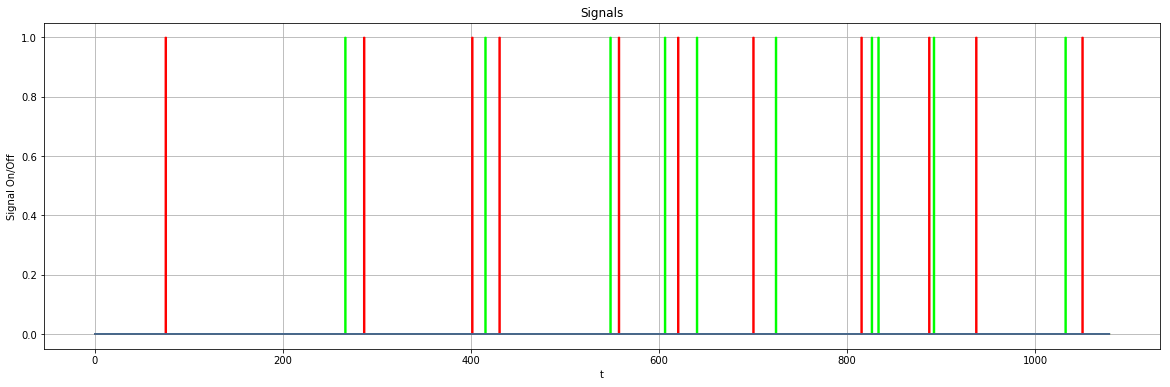

In [13]:
plt.step(range(len(chart.index)), chart['open_long'],c='lime')
plt.step(range(len(chart.index)), chart['open_short'],c='r')
plt.step(range(len(chart.index)), np.zeros(len(chart.index)))
plt.xlabel('t')
plt.ylabel('Signal On/Off')
plt.title('Signals')
plt.grid();

# Simulation

We will be using the following parameters:

1. Start with $1000
2. Lot size is 10% of our balance
3. No fees
4. 1x leverage
5. A limit stop loss that is 10% offset of our entry price

In [40]:
sim = bt.TradingSim(pd.DataFrame(chart))
sim.balance = 1000
sim.lot_size = 1
sim.fee_percentage = 0.00050
sim.leverage = 10
sim.stop_loss_type = 'limit'
sim.stop_loss_percentage = 0.0082
sim.run()

In [41]:
print('Final balance: {}'.format(sim.balance))

Final balance: 3704.852643914365


# Performance analysis

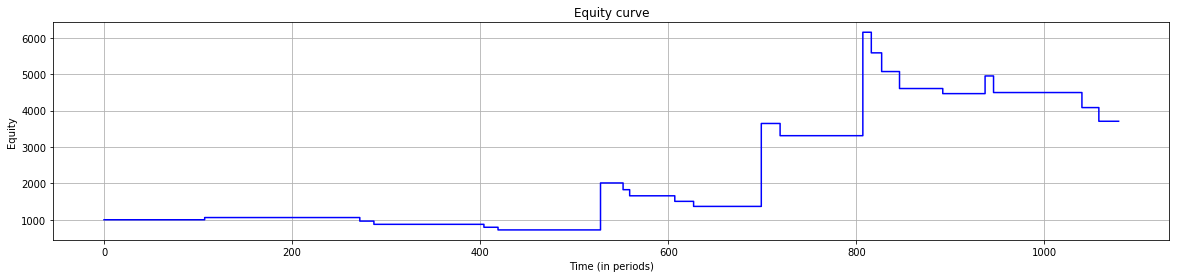

In [16]:
analysis = bt.AnalyzeSim(sim)
analysis.equity_curve().show()

In [36]:
print('There are {} trades.'.format(len(analysis.trades)))

There are 21 trades.


In [30]:
analysis.roe()

2.7048526439143652

In [31]:
analysis.paid_fees()

603.59990997312025

In [33]:
analysis.trades

,state,position_type,lot_size_base,lot_size_base_leveraged,lot_size_quote,lot_size_quote_leveraged,leverage,entry_price,exit_price,fee_percentage,stop_loss,stop_loss_percentage,stop_loss_price,order_cost,market_value,pl,pl_percent,paid_fees
0,closed,short,1000.000000,10000.000000,0.095797,0.957968,10,10438.764502,10365.335355,0.0005,limit,0.0082,10524.362371,10000.000000,9929.657243,60.377928,1.007084,9.964829
1,stopped,long,1060.377928,10603.779282,0.112555,1.125547,10,9420.999999,9343.747799,0.0005,limit,0.0082,9343.747799,10603.779282,10516.828292,-97.511294,0.991800,10.560304
2,stopped,short,962.866634,9628.666343,0.106313,1.063133,10,9056.879600,9131.146012,0.0005,limit,0.0082,9131.146012,9628.666343,9707.621407,-88.623208,0.991867,9.668144
3,stopped,short,874.243426,8742.434264,0.103225,1.032254,10,8469.265963,8538.713944,0.0005,limit,0.0082,8538.713944,8742.434264,8814.122225,-80.466239,0.991867,8.778278
4,stopped,long,793.777187,7937.771872,0.089430,0.894296,10,8876.000000,8803.216800,0.0005,limit,0.0082,8803.216800,7937.771872,7872.682143,-72.994956,0.991800,7.905227
5,closed,short,720.782231,7207.822308,0.083745,0.837446,10,8606.907445,7058.894148,0.0005,limit,0.0082,8677.484086,7207.822308,5911.444388,1289.818288,1.219300,6.559633
6,stopped,long,2010.600518,20106.005184,0.296252,2.962525,10,6786.780000,6731.128404,0.0005,limit,0.0082,6731.128404,20106.005184,19941.135941,-184.892813,0.991800,20.023571
7,stopped,short,1825.707705,18257.077053,0.267026,2.670263,10,6837.182992,6893.247892,0.0005,limit,0.0082,6893.247892,18257.077053,18406.785085,-168.039963,0.991867,18.331931
8,stopped,long,1657.667742,16576.677424,0.245306,2.453061,10,6757.549235,6702.137332,0.0005,limit,0.0082,6702.137332,16576.677424,16440.748669,-152.437468,0.991800,16.508713
9,stopped,short,1505.230274,15052.302745,0.220414,2.204142,10,6829.100000,6885.098620,0.0005,limit,0.0082,6885.098620,15052.302745,15175.731627,-138.542900,0.991867,15.114017


In [37]:
print('There are {} stopped trades.'.format(len(analysis.trades.loc[analysis.trades['state'] == 'stopped'])))
analysis.trades.loc[analysis.trades['state'] == 'stopped']

There are 15 stopped trades.


,state,position_type,lot_size_base,lot_size_base_leveraged,lot_size_quote,lot_size_quote_leveraged,leverage,entry_price,exit_price,fee_percentage,stop_loss,stop_loss_percentage,stop_loss_price,order_cost,market_value,pl,pl_percent,paid_fees
1,stopped,long,1060.377928,10603.779282,0.112555,1.125547,10,9420.999999,9343.747799,0.0005,limit,0.0082,9343.747799,10603.779282,10516.828292,-97.511294,0.991800,10.560304
2,stopped,short,962.866634,9628.666343,0.106313,1.063133,10,9056.879600,9131.146012,0.0005,limit,0.0082,9131.146012,9628.666343,9707.621407,-88.623208,0.991867,9.668144
3,stopped,short,874.243426,8742.434264,0.103225,1.032254,10,8469.265963,8538.713944,0.0005,limit,0.0082,8538.713944,8742.434264,8814.122225,-80.466239,0.991867,8.778278
4,stopped,long,793.777187,7937.771872,0.089430,0.894296,10,8876.000000,8803.216800,0.0005,limit,0.0082,8803.216800,7937.771872,7872.682143,-72.994956,0.991800,7.905227
6,stopped,long,2010.600518,20106.005184,0.296252,2.962525,10,6786.780000,6731.128404,0.0005,limit,0.0082,6731.128404,20106.005184,19941.135941,-184.892813,0.991800,20.023571
7,stopped,short,1825.707705,18257.077053,0.267026,2.670263,10,6837.182992,6893.247892,0.0005,limit,0.0082,6893.247892,18257.077053,18406.785085,-168.039963,0.991867,18.331931
8,stopped,long,1657.667742,16576.677424,0.245306,2.453061,10,6757.549235,6702.137332,0.0005,limit,0.0082,6702.137332,16576.677424,16440.748669,-152.437468,0.991800,16.508713
9,stopped,short,1505.230274,15052.302745,0.220414,2.204142,10,6829.100000,6885.098620,0.0005,limit,0.0082,6885.098620,15052.302745,15175.731627,-138.542900,0.991867,15.114017
11,stopped,short,3644.134886,36441.348862,0.448278,4.482777,10,8129.190992,8195.850358,0.0005,limit,0.0082,8195.850358,36441.348862,36740.167923,-335.409819,0.991867,36.590758
13,stopped,short,6149.591551,61495.915510,0.675915,6.759153,10,9098.169080,9172.774067,0.0005,limit,0.0082,9172.774067,61495.915510,62000.182018,-566.014556,0.991867,61.748049


# Fibonacci levels

We can use this to calculate the Fibonacci level between two points.

In [21]:
a = 9174 # crossover price EMA55
b = 8135 # high of crossover candle if long, low of crossover if short
r = a-b
f5 = a-r*0.5
f618 = a-r*0.618
f702 = a-r*0.702
f702

8444.622

Actually it can be done for any level.

In [22]:
def getFib(crossover_price, candle_high_low, lvl): return crossover_price-(crossover_price-candle_high_low)*lvl

We are using `0.702` which is a mid-level.

In [23]:
getFib(9174, 8135, .702) # Long

8444.622

In [24]:
getFib(8135, 9174, .702) # Short

8864.378

Generating the Fibonacci sequence.

In [25]:
def fibo(n):
    a = 1
    b = 1
    print(1)
    print(1)
    for _ in range(n):
        c=a+b
        a=b
        b=c
        print(c)

In [26]:
fibo(25)

1
1
2
3
5
8
13
21
34
55
89
144
233
377
610
987
1597
2584
4181
6765
10946
17711
28657
46368
75025
121393
196418
